# Store sales prediction with `etna` libarary 🌋

<a href="https://github.com/tinkoff-ai/etna">
    <img src="https://img.shields.io/badge/GitHub-100000?style=for-the-badge&logo=github&logoColor=white"  align='left'>
</a>

In this notebook we will make predictions for [Store Sales - Time Series Forecasting competition](https://www.kaggle.com/c/store-sales-time-series-forecasting) with [etna time series library](https://github.com/tinkoff-ai/etna/).

In [ ]:
!pip install etna==1.3.3 --ignore-installed -q 2> /dev/null

In [ ]:
import pathlib

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from IPython.display import display


sns.set(font_scale=1.3)

In [ ]:
DATA_PREFIX = pathlib.PurePath("/kaggle/input/store-sales-time-series-forecasting")
HORIZON = 16
NUM_DAYS_TRAIN = 200

# Dataset

In this section we will work with competition datasets.

## Loading data

Let's load all relevant datasets.

In [ ]:
train = pd.read_csv(
    DATA_PREFIX.joinpath("train.csv"), 
    parse_dates=["date"], 
    infer_datetime_format=True,
)
train.head()

In [ ]:
test = pd.read_csv(
    DATA_PREFIX.joinpath("test.csv"), 
    parse_dates=["date"], 
    infer_datetime_format=True,
)
test.head()

In [ ]:
stores = pd.read_csv(DATA_PREFIX.joinpath("stores.csv"))
stores.head()

In [ ]:
transactions = pd.read_csv(DATA_PREFIX.joinpath("transactions.csv"))
transactions.head()

## Creating `TSDataset`

To work with etna library we should create a `TSDataset`. This is a special structure that holds many time series.

We are going to use not all data, but only last `NUM_DAYS_TRAIN` days.

In [ ]:
start_date = train["date"].max() - pd.Timedelta(NUM_DAYS_TRAIN, "D")

Let's make some processing:
1. Drop `id` and `onpromotion`, because they seem to be not very useful.
2. Create such column as `segment`. It indicates different time series within dataset. In our case segment is determined by store and family of product.
3. Rename columns. Library requires that column with time should be named as `timestamp` and column with variable to predict as `target`.
4. Apply `np.log1p` function to `target`, because we calculate metric based on them.
4. Create regressors. These are exogenous factors that will be known in future. In our case it is `store_nbr` and `family`.

In [ ]:
def prepare_df(df, start_date=None, num_segments=None):
    df = df.drop(columns=["onpromotion", "id"])
    df["segment"] = [f"{x}::{y}" for x, y in zip(df["store_nbr"], df["family"])]
    df.rename(columns={
        "date": "timestamp", 
        "sales": "target", 
    }, inplace=True)
    
    if start_date is not None:
        df = df[df["timestamp"] >= start_date]
        
    if num_segments is not None:
        segments = df["segment"].unique()[:num_segments]
        df = df[df["segment"].isin(segments)]
    
    df = df[["timestamp", "segment", "target"]]
    df["target"] = np.log1p(df["target"])
    
    start_date = df["timestamp"].min()
    end_date = df["timestamp"].max() + pd.Timedelta(HORIZON, "D")
    timestamp = pd.date_range(start=start_date, end=end_date, freq="D")
    df_exog_list = []
    df_exog_segment_template = pd.DataFrame({"timestamp": timestamp})
    for segment in tqdm(df["segment"].unique()):
        df_exog_segment = df_exog_segment_template.copy()
        df_exog_segment["segment"] = segment
        df_exog_segment["regressor_store_nbr"] = segment.split("::")[0]
        df_exog_segment["regressor_family"] = segment.split("::")[1]
        df_exog_list.append(df_exog_segment)
    
    df_exog = pd.concat(df_exog_list, ignore_index=True)
    df_exog["regressor_store_nbr"] = df_exog["regressor_store_nbr"].astype("category")
    df_exog["regressor_family"] = df_exog["regressor_family"].astype("category")
    
    return df, df_exog

In [ ]:
train, train_exog = prepare_df(train, start_date=start_date)

In [ ]:
train.head()

In [ ]:
train_exog.head()

Now let's create an instance of `TSDataset`.

In [ ]:
from etna.datasets import TSDataset

ts = TSDataset(
    df=TSDataset.to_dataset(train), 
    df_exog=TSDataset.to_dataset(train_exog), 
    freq="D"
)

We can look at all segments in dataset.

In [ ]:
ts.segments[:10]

Get list of all regressors.

In [ ]:
ts.regressors

Visualize some segments.

In [ ]:
ts.plot(segments=["10::DAIRY", "8::BOOKS", "6::CLEANING", "4::MEATS"])

# Validation

This section is dedicated to validation different model with different parameters.

## Selecting transformers

Here let's create some transforms to the dataset:
1. `SegmentEncoderTransform`: makes regressors out of segments.
2. `LagTransform`: creates lag features. Our model won't use lags less than `HORIZON` to make forecasting in regression fashion.
3. `DateFlagsTransform`: creates features related to datetime.

In [ ]:
from etna.transforms import LagTransform, DateFlagsTransform, SegmentEncoderTransform

num_lags = 10

transforms = [
    SegmentEncoderTransform(),
    LagTransform(in_column="target", lags=[HORIZON + i for i in range(num_lags)]),
    DateFlagsTransform(day_number_in_week=True, day_number_in_month=True, is_weekend=True),
]

## Backtest

We are going to run a backtest. This is a special cross validation for time series that takes into account ordering by timestamp. The base idea is simple: don't validate on the past.

In our backtest each split's size is equal to the horizon and we validate on the latest `n_folds` splits. You can take or not take the whole history depending on `mode` parameter.

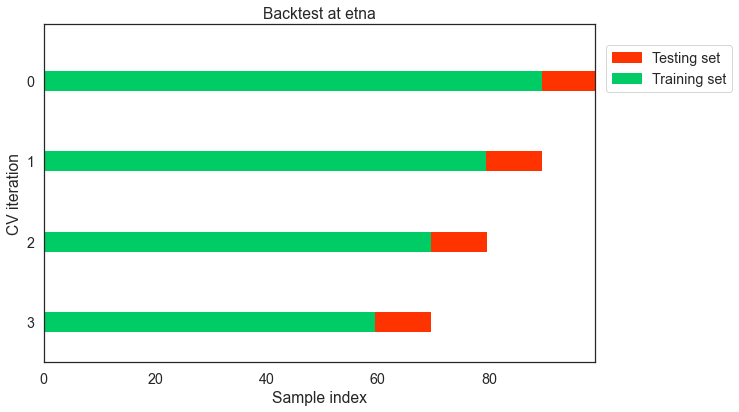

Let's create a `Pipeline`. It takes in a model, horizon and list of transforms. We are going to use a `CatBoostModelMultiSegment`: CatBoost regression model that fits on all segments simultaneously.

In [ ]:
from etna.models import CatBoostModelMultiSegment
from etna.pipeline import Pipeline
from etna.metrics import MSE

model = CatBoostModelMultiSegment(logging_level="Silent")
pipeline = Pipeline(model=model, horizon=HORIZON, transforms=transforms)

In [ ]:
metrics_df, forecast_df, fold_info_df = pipeline.backtest(
    ts=ts, metrics=[MSE()], n_folds=3
)

We are interested only in `metrics_df`, it contains metric for each segment and each fold.

In [ ]:
metrics_df.head()

We can modify it to get metric used in competition.

In [ ]:
metric = metrics_df["MSE"].mean()**(1/2)
print(f"RMSLE: {metric:.4f}")

As a result, we have a validation procedure to adjust our hyperparameters. A custom script with [Optuna](https://optuna.org/) can be written to do this.

# Training

First, let's create a logger object to monitor the process.

In [ ]:
from etna.loggers import tslogger, ConsoleLogger

tslogger.add(ConsoleLogger())

In [ ]:
tslogger.log("Hello")

Save selected transforms.

In [ ]:
num_lags = 10

transforms = [
    SegmentEncoderTransform(),
    LagTransform(in_column="target", lags=[HORIZON + i for i in range(num_lags)]),
    DateFlagsTransform(day_number_in_week=True, day_number_in_month=True, is_weekend=True),
]

## Fitting the model

We are going to use `Pipeline` here as well.

In [ ]:
model = CatBoostModelMultiSegment(logging_level="Silent")
pipeline = Pipeline(model=model, horizon=HORIZON, transforms=transforms)

In [ ]:
pipeline.fit(ts=ts)

Finally, make a forecast.

In [ ]:
forecasted = pipeline.forecast()

# Submission

In this section we will construct the submission.

In [ ]:
sample_submission = pd.read_csv(DATA_PREFIX.joinpath("sample_submission.csv"))
sample_submission.head()

In [ ]:
test.head()

In this competition there are segments on test, that are absent on train. We are going to predict these segments as 0.

In [ ]:
forecasted_target = forecasted[:, :, "target"]

sales = sample_submission["sales"].copy()
for i, row in tqdm(test.iterrows(), total=test.shape[0]):
    date = row["date"]
    segment = f"{row['store_nbr']}::{row['family']}"
    try:
        target = forecasted_target.loc[date, segment].item()
        sales.iloc[i] = target
    except IndexError:
        pass

In [ ]:
sales.describe()

As se can see, there are some abnormal values less than zero. Let's get rid of this and apply inverse transformation to our target.

In [ ]:
sample_submission["sales"] = np.expm1(np.maximum(sales, 0))

In [ ]:
sample_submission.to_csv("submission.csv", index=False)

The submission can be sent now.

If you want to know more about the etna library welcome to [our github page](https://github.com/tinkoff-ai/etna) there you can see examples and link to documentation.